In [1]:
from google.cloud import bigquery
from google.cloud import aiplatform
import bigframes.pandas as bpd
import pandas as pd
from vertexai.language_models._language_models import TextGenerationModel
from bigframes.ml.cluster import KMeans
from bigframes.ml.model_selection import train_test_split

In [2]:
project_id = 'qwiklabs-gcp-04-f96ccdbc160f'
dataset_name = "ecommerce"
model_name = "customer_segmentation_model"
table_name = "customer_stats"
location = "us-central1"
client = bigquery.Client(project=project_id)
aiplatform.init(project=project_id, location=location)

In [3]:
%%bigquery
CREATE OR REPLACE TABLE ecommerce.customer_stats AS
SELECT
  user_id,
  DATE_DIFF(CURRENT_DATE(), CAST(MAX(order_created_date) AS DATE), day) AS days_since_last_order, ---RECENCY
  COUNT(order_id) AS count_orders, --FREQUENCY
  AVG(sale_price) AS average_spend --MONETARY
  FROM (
      SELECT
        user_id,
        order_id,
        sale_price,
        created_at AS order_created_date
        FROM `bigquery-public-data.thelook_ecommerce.order_items`
        WHERE
        created_at
            BETWEEN '2022-01-01' AND '2023-01-01'
  )
GROUP BY user_id;

Query is running:   0%|          |

""


In [4]:
# prompt: Convert the table ecommerce.customer_stats to a bigframes dataframe and show the top 10 records

bqdf = bpd.read_gbq(f"{project_id}.{dataset_name}.{table_name}")
bqdf.head(10)

,user_id,days_since_last_order,count_orders,average_spend
0,29178,928,1,77.360001
1,94215,743,1,173.949997
2,19019,679,6,75.246667
3,61567,845,1,43.759998
4,84917,762,4,25.49
5,54651,821,2,68.799999
6,40907,926,3,48.666667
7,4143,737,2,44.705
8,49553,864,1,59.959999
9,98190,692,2,27.450001


In [6]:
# prompt: 1. Split df (using random state and test size 0.2) into test and training data for a K-means clustering algorithm store these as df_test and df_train. 2. Create a K-means cluster model using bigframes.ml.cluster KMeans with 5 clusters. 3. Save the model using the to_gbq method where the model name is project_id.dataset_name.model_name.

df_train, df_test = train_test_split(bqdf, test_size=0.2, random_state=42)
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_train)
kmeans.to_gbq(f"{project_id}.{dataset_name}.{model_name}")

KMeans(distance_type='EUCLIDEAN', init='KMEANS_PLUS_PLUS', n_clusters=5)

In [7]:
# prompt: 1. Call the K-means prediction model on the df dataframe, and store the results as predictions_df and show the first 10 records.

predictions_df = kmeans.predict(df_test)
predictions_df.head(10)

,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,user_id,days_since_last_order,count_orders,average_spend
3,3,"[{'CENTROID_ID': 3, 'DISTANCE': 0.713597562182...",61567,845,1,43.759998
10,3,"[{'CENTROID_ID': 3, 'DISTANCE': 1.274551676547...",58563,701,1,14.97
23,3,"[{'CENTROID_ID': 3, 'DISTANCE': 0.843712867772...",74456,812,1,89.0
24,4,"[{'CENTROID_ID': 4, 'DISTANCE': 0.986378347172...",27861,712,1,13.52
27,3,"[{'CENTROID_ID': 3, 'DISTANCE': 0.811060969226...",87520,820,2,46.25
30,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.056204267599...",4290,766,2,67.054998
31,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.662266500441...",48785,655,1,22.99
50,1,"[{'CENTROID_ID': 1, 'DISTANCE': 1.144658841519...",73423,717,3,37.333333
56,4,"[{'CENTROID_ID': 4, 'DISTANCE': 0.890922836100...",18278,868,1,18.99
57,3,"[{'CENTROID_ID': 3, 'DISTANCE': 1.814683384327...",68956,633,2,23.815


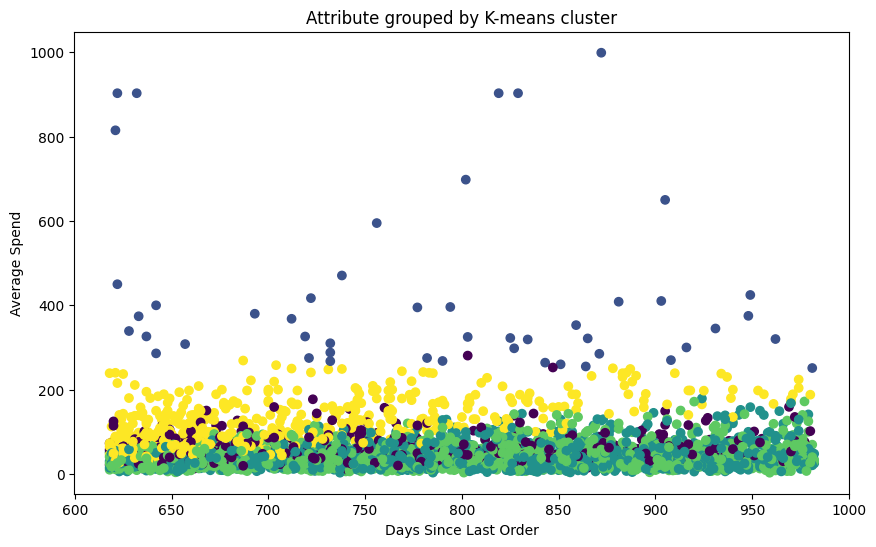

In [15]:
# prompt: 1. Using predictions_df, and matplotlib, generate a scatterplot. 2. On the x-axis of the scatterplot, display days_since_last_order and on the y-axis, display average_spend from predictions_df. 3. Color by cluster. 4. The chart should be titled "Attribute grouped by K-means cluster."

import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(predictions_df['days_since_last_order'], predictions_df['average_spend'], c=predictions_df['CENTROID_ID'], cmap='viridis')
plt.xlabel('Days Since Last Order')
plt.ylabel('Average Spend')
plt.title('Attribute grouped by K-means cluster')
plt.show()

In [16]:
query = """
SELECT
 CONCAT('cluster ', CAST(centroid_id as STRING)) as centroid,
 average_spend,
 count_orders,
 days_since_last_order
FROM (
 SELECT centroid_id, feature, ROUND(numerical_value, 2) as value
 FROM ML.CENTROIDS(MODEL `{0}.{1}`)
)
PIVOT (
 SUM(value)
 FOR feature IN ('average_spend',  'count_orders', 'days_since_last_order')
)
ORDER BY centroid_id
""".format(dataset_name, model_name)

df_centroid = client.query(query).to_dataframe()
df_centroid.head()

,centroid,average_spend,count_orders,days_since_last_order
0,cluster 1,58.30,3.72,749.29
1,cluster 2,410.87,1.22,786.64
2,cluster 3,42.47,1.30,802.41
3,cluster 4,42.42,1.31,793.44
4,cluster 5,116.48,1.33,712.57


In [17]:
df_query = client.query(query).to_dataframe()
df_query.to_string(header=False, index=False)

cluster_info = []
for i, row in df_query.iterrows():
 cluster_info.append("{0}, average spend ${2}, count of orders per person {1}, days since last order {3}"
  .format(row["centroid"], row["count_orders"], row["average_spend"], row["days_since_last_order"]) )

cluster_info = (str.join("\n", cluster_info))
print(cluster_info)

cluster 1, average spend $58.3, count of orders per person 3.72, days since last order 749.29
cluster 2, average spend $410.87, count of orders per person 1.22, days since last order 786.64
cluster 3, average spend $42.47, count of orders per person 1.3, days since last order 802.41
cluster 4, average spend $42.42, count of orders per person 1.31, days since last order 793.44
cluster 5, average spend $116.48, count of orders per person 1.33, days since last order 712.57


In [18]:
prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step.

Clusters:
{cluster_info}

For each Cluster:
* Title:
* Persona:
* Next marketing step:
"""

In [21]:
#prompt:  Use the Vertex AI language_models API to call the PaLM2 text-bison model and generate a marketing campaign using the variable prompt. Use the following model settings: max_output_tokens=1024, temperature=0.4

model = TextGenerationModel.from_pretrained("text-bison@001")
response = model.predict(prompt, max_output_tokens=1024, temperature=0.4)
print(response.text)

**Cluster 1**

* Title: The Frequent Flyers
* Persona: Young professionals who are always on the go. They love to travel and explore new places, and they're always looking for new products and services to make their lives easier.
* Next marketing step: Create a loyalty program that rewards frequent flyers with points or discounts. You could also offer special deals on products and services that are specifically designed for people who travel frequently.

**Cluster 2**

* Title: The Luxury Seekers
* Persona: Affluent consumers who are looking for the best possible experience. They're willing to pay a premium for high-quality products and services, and they're always looking for new ways to pamper themselves.
* Next marketing step: Create a high-end marketing campaign that emphasizes the luxury and exclusivity of your products or services. You could also partner with other luxury brands to create a co-branded marketing campaign.

**Cluster 3**

* Title: The Value Seekers
* Persona: Budge